In [1]:
!pip install torch torchvision matplotlib --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.7 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)

# Autoencoder with 2D bottleneck
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32*3, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 2)  # 2D feature output
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 32*32*3),
            nn.Sigmoid(),  # to keep output between 0 and 1
            nn.Unflatten(1, (3, 32, 32))
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

# Initialize model
model = AutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


100%|██████████| 170M/170M [00:06<00:00, 25.8MB/s]


In [3]:
num_epochs = 5

for epoch in range(num_epochs):
    total_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        outputs = model(images)
        loss = criterion(outputs, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")


Epoch [1/5], Loss: 0.0400
Epoch [2/5], Loss: 0.0369
Epoch [3/5], Loss: 0.0368
Epoch [4/5], Loss: 0.0366
Epoch [5/5], Loss: 0.0363


In [4]:
# Extract 2D features from some samples
model.eval()
features = []
labels = []

with torch.no_grad():
    for images, lbls in train_loader:
        images = images.to(device)
        z = model.encoder(images)
        features.append(z.cpu().numpy())
        labels.append(lbls.cpu().numpy())
        if len(features) * 256 >= 5000:
            break  # only use 5k samples for plotting

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)


/tmp/ipython-input-5-4024555617.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', 10)


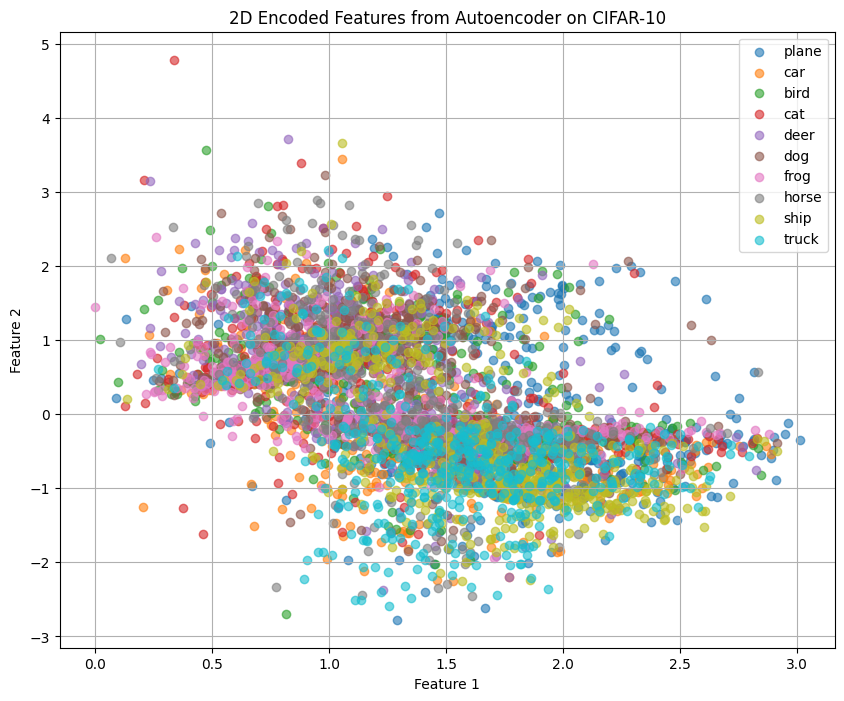

In [5]:
# CIFAR-10 label names
classes = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']
colors = plt.cm.get_cmap('tab10', 10)

plt.figure(figsize=(10, 8))
for i in range(10):
    idxs = labels == i
    plt.scatter(features[idxs, 0], features[idxs, 1], label=classes[i], alpha=0.6, color=colors(i))
plt.legend()
plt.title("2D Encoded Features from Autoencoder on CIFAR-10")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()


In [6]:
# Install required libraries
!pip install torch torchvision matplotlib scikit-learn --quiet


In [7]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224))  # needed for ResNet
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=False)


In [8]:
from torchvision.models import resnet18

resnet = resnet18(pretrained=True)
resnet.fc = nn.Identity()  # remove classifier to get features
resnet.eval().to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 118MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
features_resnet = []
labels_resnet = []

with torch.no_grad():
    for images, lbls in loader:
        images = images.to(device)
        feats = resnet(images)  # output shape: [B, 512]
        features_resnet.append(feats.cpu().numpy())
        labels_resnet.append(lbls.numpy())
        if len(features_resnet)*256 >= 5000:
            break

features_resnet = np.concatenate(features_resnet)
labels_resnet = np.concatenate(labels_resnet)


In [10]:
# PCA
pca = PCA(n_components=2)
resnet_pca_2d = pca.fit_transform(features_resnet)

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
resnet_tsne_2d = tsne.fit_transform(features_resnet)


/tmp/ipython-input-11-3119569502.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', 10)


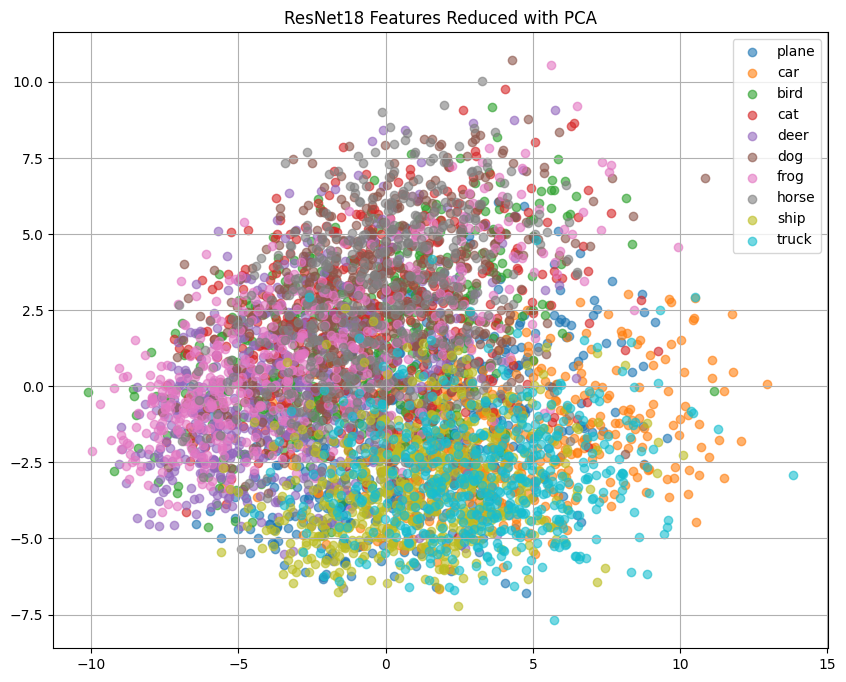

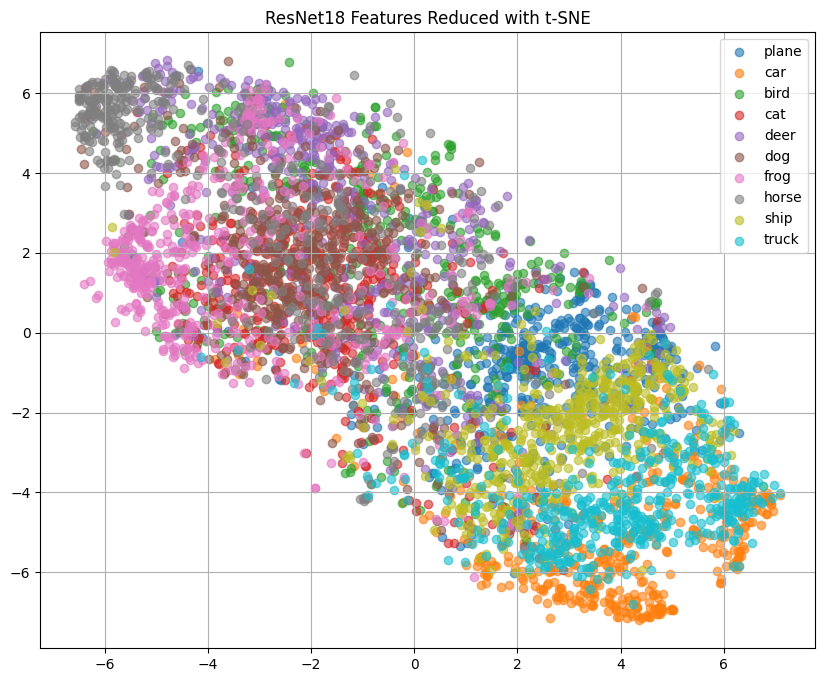

In [11]:
classes = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']
colors = plt.cm.get_cmap('tab10', 10)

def plot_features(data_2d, labels, title):
    plt.figure(figsize=(10, 8))
    for i in range(10):
        idx = labels == i
        plt.scatter(data_2d[idx, 0], data_2d[idx, 1], label=classes[i], alpha=0.6, color=colors(i))
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_features(resnet_pca_2d, labels_resnet, "ResNet18 Features Reduced with PCA")
plot_features(resnet_tsne_2d, labels_resnet, "ResNet18 Features Reduced with t-SNE")


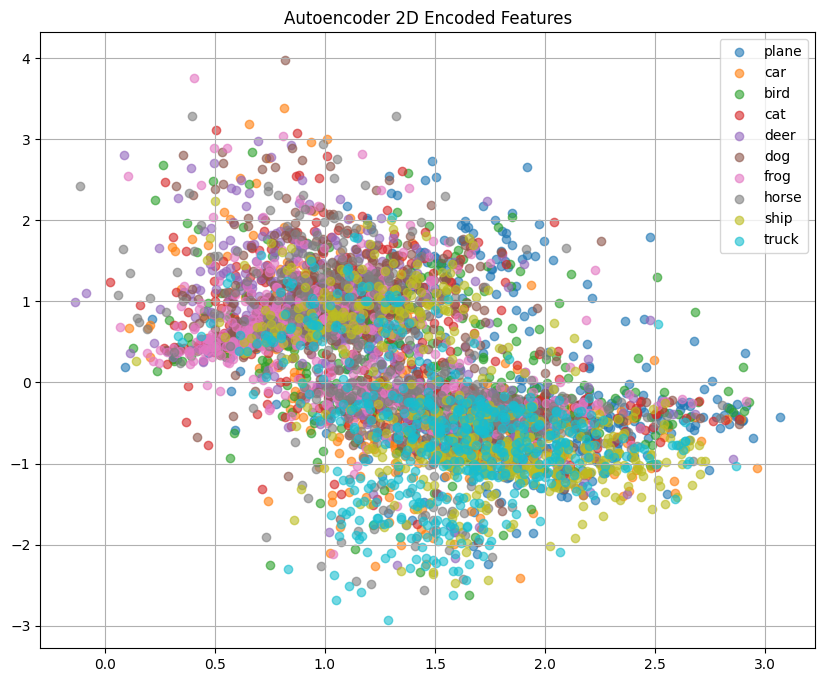

In [12]:
# Resize transform back to 32x32 for AE input
ae_transform = transforms.Compose([transforms.ToTensor()])
ae_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=ae_transform)
ae_loader = torch.utils.data.DataLoader(ae_dataset, batch_size=256, shuffle=False)

ae_features = []
ae_labels = []

with torch.no_grad():
    for imgs, lbls in ae_loader:
        imgs = imgs.to(device)
        z = model.encoder(imgs)
        ae_features.append(z.cpu().numpy())
        ae_labels.append(lbls.numpy())
        if len(ae_features)*256 >= 5000:
            break

ae_features = np.concatenate(ae_features)
ae_labels = np.concatenate(ae_labels)

plot_features(ae_features, ae_labels, "Autoencoder 2D Encoded Features")
